In [50]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np


In [ ]:

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_val, X_test = X_train/255., X_val/255., X_test/255.

X_train[0]

plt.figure(figsize=(2,2))
plt.imshow(X_train[0], cmap='binary' )

In [13]:
# Define model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32, 3]))
for index in range(1, 21):
    model.add(tf.keras.layers.Dense(100, activation="swish", kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               1

In [23]:
# Find optimal learning rate with Tensorboard
from pathlib import Path
      
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

run_index = 6 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [4]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_log

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])

In [25]:
# Use optimal learning rate to train model wirh Nadam optimizer and early stopping

from pathlib import Path

tf.keras.backend.clear_session()
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model", save_best_only=True)

run_index = 7 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
# Run model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

In [27]:
#Evaluate model on validation set
model.evaluate(X_val, y_val)

157/157 [==============================] - 0s 2ms/step - loss: 1.4650 - accuracy: 0.5256


[1.4649752378463745, 0.525600016117096]

In [29]:
# Add batch normalisation to previous model

tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32, 3]))
for index in range(1, 21):
    model.add(tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('swish'))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307200    
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10000     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                        

In [38]:
# Find batch normalisation optimal rate with Tensorboard
# runs = 1:1e-5, 2:3e-5, 3:5e-5, 4:1e-4, 5:3e-4
        
optimizer = tf.keras.optimizers.Nadam(learning_rate=3e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

run_index = 5 # increment every time you train the model
run_logdir = Path() / "my_cifar10_bn_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)


In [ ]:
# Run model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])

In [ ]:
# Use optimal learning rate to train previous model with batch normalisation

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

run_index = 7 # increment every time you train the model
run_logdir = Path() / "my_cifar10_bn_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=callbacks)

In [42]:
#Evaluate model
model.evaluate(X_val, y_val)

157/157 [==============================] - 1s 3ms/step - loss: 1.4063 - accuracy: 0.5348


[1.4063448905944824, 0.5347999930381775]

In [28]:
#Use SELU activation 

tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32, 3]))
for index in range(1, 21):
    model.add(tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

run_index = 10 # increment every time you train the model
run_logdir = Path() / "my_cifar10_selu_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_selu_model", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_val_scaled = (X_val - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [8]:
%tensorboard --logdir=./my_cifar10_selu_logs

UsageError: Line magic function `%tensorboard` not found.


In [29]:
# Run model
model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_val_scaled, y_val), callbacks=callbacks)

Epoch 1/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.8247 - accuracy: 0.3477

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 21s 12ms/step - loss: 1.8246 - accuracy: 0.3477 - val_loss: 1.7104 - val_accuracy: 0.3826
Epoch 2/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.6162 - accuracy: 0.4241

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 15s 11ms/step - loss: 1.6164 - accuracy: 0.4241 - val_loss: 1.6174 - val_accuracy: 0.4232
Epoch 3/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.5196 - accuracy: 0.4586

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 16s 11ms/step - loss: 1.5198 - accuracy: 0.4585 - val_loss: 1.5374 - val_accuracy: 0.4534
Epoch 4/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.4464 - accuracy: 0.4833

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 16s 11ms/step - loss: 1.4463 - accuracy: 0.4833 - val_loss: 1.5082 - val_accuracy: 0.4682
Epoch 5/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.3888 - accuracy: 0.5050

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 16s 11ms/step - loss: 1.3887 - accuracy: 0.5051 - val_loss: 1.4852 - val_accuracy: 0.4708
Epoch 6/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.3321 - accuracy: 0.5251

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 15s 11ms/step - loss: 1.3321 - accuracy: 0.5250 - val_loss: 1.4631 - val_accuracy: 0.4790
Epoch 7/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.2817 - accuracy: 0.5444

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 16s 11ms/step - loss: 1.2814 - accuracy: 0.5445 - val_loss: 1.4472 - val_accuracy: 0.4922
Epoch 8/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.2360 - accuracy: 0.5605

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 14s 10ms/step - loss: 1.2356 - accuracy: 0.5605 - val_loss: 1.4468 - val_accuracy: 0.4932
Epoch 9/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.1938 - accuracy: 0.5764

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 14s 10ms/step - loss: 1.1938 - accuracy: 0.5763 - val_loss: 1.4464 - val_accuracy: 0.4858
Epoch 10/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.1515 - accuracy: 0.5916

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 14s 10ms/step - loss: 1.1517 - accuracy: 0.5916 - val_loss: 1.4344 - val_accuracy: 0.4988
Epoch 11/100
1407/1407 [==============================] - ETA: 0s - loss: 1.1121 - accuracy: 0.6079

INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 14s 10ms/step - loss: 1.1121 - accuracy: 0.6079 - val_loss: 1.4338 - val_accuracy: 0.5090
Epoch 12/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.0761 - accuracy: 0.6197 - val_loss: 1.4586 - val_accuracy: 0.5010
Epoch 13/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.0417 - accuracy: 0.6306 - val_loss: 1.4581 - val_accuracy: 0.5070
Epoch 14/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.0045 - accuracy: 0.6434 - val_loss: 1.4943 - val_accuracy: 0.5008
Epoch 15/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.9726 - accuracy: 0.6531 - val_loss: 1.5042 - val_accuracy: 0.5062
Epoch 16/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.9386 - accuracy: 0.6701 - val_loss: 1.5189 - val_accuracy: 0.5110
Epoch 17/100
1407/1407 [==============================] - 15s 11ms/step - loss: 0.9076 - accuracy: 0.6802 - val_loss: 1.5512 

In [30]:
# Evaluate model
model.evaluate(X_val_scaled, y_val)

157/157 [==============================] - 0s 2ms/step - loss: 1.4338 - accuracy: 0.5090


[1.4338300228118896, 0.5090000033378601]

In [43]:
#Use alpha dropout with SELU

tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32, 3]))
for index in range(1, 21):
    model.add(tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    
model.add(tf.keras.layers.AlphaDropout(rate=0.15))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

run_index = 7 # increment every time you train the model
run_logdir = Path() / "my_cifar10_alpha_dropout_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_val_scaled = (X_val - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [ ]:
%tensorboard --logdir=./my_cifar10_selu_logs

In [44]:
# Run model
model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_val_scaled, y_val), callbacks=callbacks)

Epoch 1/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.8964 - accuracy: 0.3274

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 23s 14ms/step - loss: 1.8964 - accuracy: 0.3275 - val_loss: 1.7943 - val_accuracy: 0.3830
Epoch 2/100
1407/1407 [==============================] - ETA: 0s - loss: 1.6785 - accuracy: 0.4086

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 18s 13ms/step - loss: 1.6785 - accuracy: 0.4086 - val_loss: 1.7083 - val_accuracy: 0.4230
Epoch 3/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.5970 - accuracy: 0.4391

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 19s 13ms/step - loss: 1.5969 - accuracy: 0.4392 - val_loss: 1.6218 - val_accuracy: 0.4528
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5295 - accuracy: 0.4648 - val_loss: 1.6454 - val_accuracy: 0.4590
Epoch 5/100
1407/1407 [==============================] - ETA: 0s - loss: 1.4687 - accuracy: 0.4875

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 19s 13ms/step - loss: 1.4687 - accuracy: 0.4875 - val_loss: 1.6181 - val_accuracy: 0.4674
Epoch 6/100
1407/1407 [==============================] - ETA: 0s - loss: 1.4229 - accuracy: 0.5026

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 19s 13ms/step - loss: 1.4229 - accuracy: 0.5026 - val_loss: 1.6167 - val_accuracy: 0.4832
Epoch 7/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.3798 - accuracy: 0.5191

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 18s 13ms/step - loss: 1.3801 - accuracy: 0.5190 - val_loss: 1.5865 - val_accuracy: 0.4854
Epoch 8/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.3414 - accuracy: 0.5337 - val_loss: 1.5956 - val_accuracy: 0.4926
Epoch 9/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.3017 - accuracy: 0.5497 - val_loss: 1.5982 - val_accuracy: 0.4796
Epoch 10/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.2748 - accuracy: 0.5559 - val_loss: 1.6208 - val_accuracy: 0.5084
Epoch 11/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.2414 - accuracy: 0.5715

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 17s 12ms/step - loss: 1.2415 - accuracy: 0.5714 - val_loss: 1.5553 - val_accuracy: 0.4954
Epoch 12/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.2112 - accuracy: 0.5817

INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 17s 12ms/step - loss: 1.2113 - accuracy: 0.5816 - val_loss: 1.5214 - val_accuracy: 0.5052
Epoch 13/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.1823 - accuracy: 0.5933 - val_loss: 1.6356 - val_accuracy: 0.5016
Epoch 14/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.1607 - accuracy: 0.6014 - val_loss: 1.5551 - val_accuracy: 0.5074
Epoch 15/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.1272 - accuracy: 0.6123 - val_loss: 1.6317 - val_accuracy: 0.5126
Epoch 16/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.1104 - accuracy: 0.6183 - val_loss: 1.6480 - val_accuracy: 0.5088
Epoch 17/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.0897 - accuracy: 0.6248 - val_loss: 1.6997 - val_accuracy: 0.5050
Epoch 18/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.0631 - accuracy: 0.6355 - val_loss: 1.6194 

In [45]:
# Evaluate model
model.evaluate(X_val_scaled, y_val)

157/157 [==============================] - 0s 2ms/step - loss: 1.5214 - accuracy: 0.5052


[1.5213507413864136, 0.5052000284194946]

In [48]:
class MCAlphaDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)

In [51]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate) 
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer 
    )
    for layer in model.layers
])

def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

In [52]:
y_pred = mc_dropout_predict_classes(mc_model, X_val_scaled)
accuracy = (y_pred == y_val[:, 0]).mean()
accuracy

157/157 [==============================] - 0s 2ms/step


0.4996

In [53]:
# Retrain model using 1cycle scheduling
import math
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)
                    
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses
    
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

352/352 [==============================] - 6s 11ms/step - loss: nan - accuracy: 0.1783


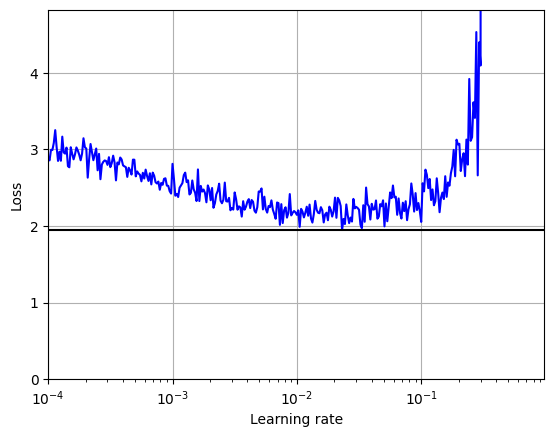

In [54]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32, 3]))
for index in range(1, 21):
    model.add(tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    
model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [55]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

In [57]:
optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 7s 18ms/step - loss: 2.0500 - accuracy: 0.2848 - val_loss: 1.7799 - val_accuracy: 0.3660
Epoch 2/15
352/352 [==============================] - 5s 13ms/step - loss: 1.7632 - accuracy: 0.3703 - val_loss: 1.6670 - val_accuracy: 0.4174
Epoch 3/15
352/352 [==============================] - 5s 13ms/step - loss: 1.6301 - accuracy: 0.4199 - val_loss: 1.6929 - val_accuracy: 0.4060
Epoch 4/15
352/352 [==============================] - 5s 13ms/step - loss: 1.5573 - accuracy: 0.4450 - val_loss: 1.6437 - val_accuracy: 0.4372
Epoch 5/15
352/352 [==============================] - 5s 13ms/step - loss: 1.5026 - accuracy: 0.4684 - val_loss: 1.6708 - val_accuracy: 0.4200
Epoch 6/15
352/352 [==============================] - 5s 13ms/step - loss: 1.4635 - accuracy: 0.4804 - val_loss: 1.5895 - val_accuracy: 0.4508
Epoch 7/15
352/352 [==============================] - 5s 13ms/step - loss: 1.4270 - accuracy: 0.4940 - val_loss: 1.5806 - val_accuracy: 0.4662

In [58]:
model.evaluate(X_val_scaled, y_val)

157/157 [==============================] - 0s 3ms/step - loss: 1.5490 - accuracy: 0.5290


[1.5489990711212158, 0.5289999842643738]